In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
from sklearn import linear_model
from sklearn import preprocessing
import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import scatter_matrix
import json
import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa import ar_model
from statsmodels.tsa.arima_model import ARIMA

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def convert_datetime(name):
    json = pd.read_json('../data/oss_downloads/' + name + '_download.json')
    df_json = pd.DataFrame(json['downloads'])
    df = json_normalize(df_json['downloads'])
    df['day'] = pd.to_datetime(df['day'], infer_datetime_format=False)
    df.index = df['day']
    return df

def convert_stateofjsDf(category):
    json = pd.read_json('../data/assets/target_oss/' + category + '_stateofjs.json')
    df_json = pd.DataFrame(json)    
    name = df_json['id']
    satisfaction2019 = df_json['satisfaction'].map( lambda x: x[3]['percentage'])
    satisfaction2018 = df_json['satisfaction'].map( lambda x: x[2]['percentage'])
    df = pd.DataFrame({'name': name, "satisfaction_2019" : satisfaction2019, 'satisfaction_2018': satisfaction2018 })
    return df

def convert_star_week_datatime(name):
    name = name.split('/')
    fname = 'data/stars/' + name[0] +'_' + name[1] + '_stars.json'
    pkg = pd.read_json(fname)
    pkg = pd.Series(pd.to_datetime(pkg['staredAts'])).dt.date
    github_life = np.arange('2016-09-04', '2019-09-02', dtype='datetime64[D]')
    github_life = pd.Series(github_life, name='t').dt.date
    star_counts = []
    for d in github_life:
        count = pkg[pkg == d].count()
        star_counts.append(count)
    starsCount = pd.Series(star_counts, index=pd.date_range('2016-09-04', '2019-09-01'))
    return round(starsCount.resample(rule='W').mean())

def convert_week_datetime(name):
    df = convert_datetime(name)
    df_w = round(df.resample(rule="W").mean())
    return df_w

def convert_ts(name):
    df_w = convert_week_datetime(name)
    ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
    return ts

In [4]:
mobile = convert_stateofjsDf('mobile')
testing = convert_stateofjsDf('testing')
backend = convert_stateofjsDf('backend')
datalayer = convert_stateofjsDf('datalayer')
# jsflaver = convert_stateofjsDf('jsflaver')

In [5]:
oss_satisfaction = pd.concat([mobile, testing, backend, datalayer], ignore_index=True)
oss_satisfaction

,name,satisfaction_2019,satisfaction_2018
0,electron,85.7,87.1
1,reactnative,82.1,83.8
2,cordova,28.0,34.3
3,ionic,40.6,51.5
4,nwjs,32.6,NaN
5,expo,73.8,NaN
6,jest,96.4,96.5
7,mocha,77.7,82.3
8,storybook,91.9,89.1
9,cypress,93.2,NaN


In [6]:
# とりあえずデータの基盤を作る
stateofjsname = [
    'electron',
    'react-native',
    'cordova',
    'ionic',
    'nwjs',
    'expo',
    
    
    'jest',
    'mocha',
    '@storybook::react',
    'cypress',
    'enzyme',
    'ava',
    'jasmine',
    'puppeteer',
    
    
    "express",
    'next',
    'koa',
    'meteor',
    'sails',
    '@feathersjs::feathers',
    'nuxt',
    'gatsby',

    'redux',
    'apollo',
    'graphql',
    'react-relay',
    'mobx',
    
#     'typescript',
#     'reason',
#     'elm',
#     'purescript',
    
]
download2019 = []
download2018 = []
download2017 = []
grate2019 = []
grate2018 = []
trend2017 = []
trend2018 = []
trend2019 = []

for name in stateofjsname:
    json = convert_datetime(name)
    ts = convert_ts(name)
    trend = ts.trend[26:130]
    
    trend201709 = round(trend[1], 3)
    trend201809 = round(trend[52], 3)
    trend201909 = round(trend[103])

    download201709 = json['downloads']['2017-09-01']
    download201809 = json['downloads']['2018-09-01']
    download201909 = json['downloads']['2019-09-01']
    
    #  download より算出する場合
    #     grate201809 = round( json['downloads'].pct_change(freq='365D')['2018-09-01'], 3)
    #     grate201909 = round( json['downloads'].pct_change(freq='365D')['2019-09-01'], 3)

    grate201809 = round( (trend201809 / trend201709) , 3)
    grate201909 = round( (trend201909 / trend201809) , 3)
    
    trend2017.append(trend201709)
    trend2018.append(trend201809)
    trend2019.append(trend201909)
    
    download2017.append(download201709)
    download2018.append(download201809)
    download2019.append(download201909)
    
    grate2018.append(grate201809)
    grate2019.append(grate201909)

    
SeriesTrend2017 =  pd.Series(trend2017, name="trend_2017")
SeriesTrend2018 =  pd.Series(trend2018, name="trend_2018")
SeriesTrend2019 =  pd.Series(trend2019, name="trend_2019")

SeriesDownload2017 = pd.Series(download2017, name="download_2017")
SeriesDownload2018 = pd.Series(download2018, name="download_2018")
SeriesDownload2019 = pd.Series(download2019, name="download_2019")

SeriesGrate2019 = pd.Series(grate2019, name="grate_2019")
SeriesGrate2018 = pd.Series(grate2018, name="grate_2018")

df = pd.concat([
    oss_satisfaction,
    SeriesDownload2017,
    SeriesDownload2018,
    SeriesDownload2019, 
    SeriesTrend2017, 
    SeriesTrend2018, 
    SeriesTrend2019,
    SeriesGrate2019,
    SeriesGrate2018,
], axis=1)
df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


,name,satisfaction_2019,satisfaction_2018,download_2017,download_2018,download_2019,trend_2017,trend_2018,trend_2019,grate_2019,grate_2018
0,electron,85.7,87.1,13749,8630,12401,8832.029,17852.385,29508.0,1.653,2.021
1,reactnative,82.1,83.8,24073,10327,12176,10134.808,22497.856,35333.0,1.571,2.220
2,cordova,28.0,34.3,23962,24008,7598,15184.875,19221.846,25891.0,1.347,1.266
3,ionic,40.6,51.5,14736,3510,3974,15264.779,14289.452,9155.0,0.641,0.936
4,nwjs,32.6,NaN,22,10,8,21.058,22.952,46.0,2.004,1.090
5,expo,73.8,NaN,4074,2798,3304,661.875,4043.837,6378.0,1.577,6.110
6,jest,96.4,96.5,82722,65517,180185,32089.644,163210.269,480968.0,2.947,5.086
7,mocha,77.7,82.3,213880,111353,153288,161977.317,240394.221,354632.0,1.475,1.484
8,storybook,91.9,89.1,9721,9607,19629,1559.923,24516.240,74621.0,3.044,15.716
9,cypress,93.2,NaN,151,3664,17249,14.404,6574.346,43684.0,6.645,456.425


In [33]:
df.to_csv('2020OSS.csv')

In [51]:
# 2019 と 2018 をがっちゃんこさせる
# 
#　増加率と前年の値について

name = np.concatenate([df['name'].values, df['name'].values], 0)
satisfaction = np.concatenate([df['satisfaction_2019'].values, df['satisfaction_2018'].values], 0)
satisfaction = np.array([ i * 0.01  for i in satisfaction ])
download = np.concatenate([df['download_2019'].values, df['download_2018'].values], 0)
# 対数変換
download  = np.array([np.log10(i) for i in download])

rate_of_change = np.concatenate([df['grate_2019'].values, df['grate_2018'].values], 0)

# 相関係数あがるけど、前年比は対数変換しない
# rate_of_change = np.array([np.log10(i) for i in rate_of_change])
# min - max スケーリング
# mscaler = preprocessing.MinMaxScaler()
# mscaler.fit(rate_of_change)
# rate_of_change = mscaler.transform(rate_of_change)

download_last_year = np.concatenate([df['download_2018'].values, df['download_2017'].values], 0)
# 対数変換
download_last_year  = np.array([np.log10(i) for i in download_last_year])

trend = np.concatenate([df['trend_2019'].values, df['trend_2018'].values], 0)
# 対数変換
trend  = np.array([np.log10(i) for i in trend])

mobile = np.concatenate([
    np.full(6, 1), np.full(8, 0), np.full(8, 0), np.full(5, 0), 
    np.full(6, 1), np.full(8, 0), np.full(8, 0), np.full(5, 0) ] , 0)

testing = np.concatenate([
    np.full(6, 0), np.full(8, 1), np.full(8, 0), np.full(5, 0), 
    np.full(6, 0), np.full(8, 1), np.full(8, 0), np.full(5, 0),] , 0)

backend = np.concatenate([
    np.full(6, 0), np.full(8, 0), np.full(8, 1), np.full(5, 0), 
    np.full(6, 0), np.full(8, 0), np.full(8, 1), np.full(5, 0), ] , 0)

datalayer = np.concatenate([
    np.full(6, 0), np.full(8, 0), np.full(8, 0), np.full(5, 1),
    np.full(6, 0), np.full(8, 0), np.full(8, 0), np.full(5, 1) ] , 0)

# flaver = np.concatenate([
#     np.full(6, 0), np.full(8, 0), np.full(8, 0), np.full(5, 0), np.full(4, 1), 
#     np.full(6, 0), np.full(8, 0), np.full(8, 0), np.full(5, 0), np.full(4, 1) ] , 0)

stateofjs = pd.DataFrame(
    { "name": name,
      "satisfaction": satisfaction,
      "download": download,
      "rate_of_change": rate_of_change,
      "download_last_year": download_last_year,
      "trend": trend,
      "mobile": mobile,
      "testing": testing,
      "backend": backend,
      "datalayer": datalayer
    }
)

stateofjs = stateofjs.dropna().reset_index(drop=True)
stateofjs = stateofjs.drop(23)
stateofjs = stateofjs.drop(33)
stateofjs = stateofjs.drop(42)
stateofjs = stateofjs.drop(44)
stateofjs

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


,name,satisfaction,download,rate_of_change,download_last_year,trend,mobile,testing,backend,datalayer
0,electron,0.857,4.093457,1.653,3.936011,4.469940,1,0,0,0
1,reactnative,0.821,4.085505,1.571,4.013974,4.548181,1,0,0,0
2,cordova,0.280,3.880699,1.347,4.380356,4.413149,1,0,0,0
3,ionic,0.406,3.599228,0.641,3.545307,3.961658,1,0,0,0
4,nwjs,0.326,0.903090,2.004,1.000000,1.662758,1,0,0,0
5,expo,0.738,3.519040,1.577,3.446848,3.804685,1,0,0,0
6,jest,0.964,5.255719,2.947,4.816354,5.682116,0,1,0,0
7,mocha,0.777,5.185508,1.475,5.046702,5.549778,0,1,0,0
8,storybook,0.919,4.292898,3.044,3.982588,4.872861,0,1,0,0
9,cypress,0.932,4.236764,6.645,3.563955,4.640322,0,1,0,0


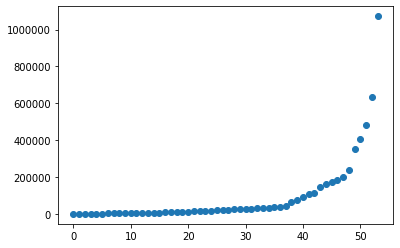

In [31]:
trend_row = np.concatenate([df['trend_2019'].values, df['trend_2018'].values], 0)
sort = np.sort(trend_row)[::1]
sort
# plt.plot(sort)
plt.scatter(np.array(range(sort.size)), sort)
# t_row = pd.DataFrame({ "download":trend})
# t_row.hist()

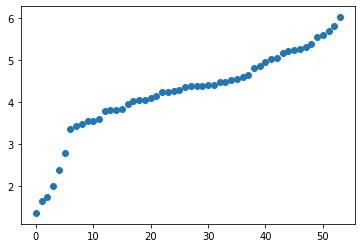

In [32]:
cotrend = np.concatenate([df['trend_2019'].values, df['trend_2018'].values], 0)
# 対数変換
log_trend  = np.array([np.log10(i) for i in cotrend])
cosort = np.sort(log_trend)[::1]
plt.scatter(np.array(range(cosort.size)), cosort)

# log_trend  = np.array([np.log(i) for i in cotrend])
# t = pd.DataFrame({ "download":log_trend})
# t.hist()

[[nan nan]
 [nan  1.]]
[85.7 82.1 28.  40.6 32.6 73.8 96.4 77.7 91.9 93.2 71.3 63.4 66.9 89.1
 92.6 90.5 80.2 27.6 26.1 52.8 88.5 88.4 70.7 89.8 94.8 53.3 69.5 87.1
 83.8 34.3 51.5  nan  nan 96.5 82.3 89.1  nan 88.4 71.6 74.8  nan 94.3
 88.3 84.8 37.6 28.1 68.5  nan  nan 82.1 92.9 94.2 45.8 77.7]


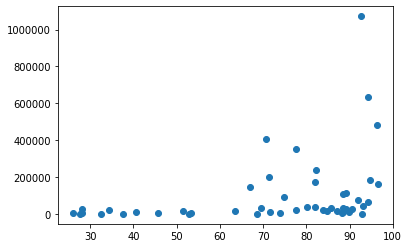

In [42]:
x = np.concatenate([df['satisfaction_2019'].values, df['satisfaction_2018'].values], 0)
plt.scatter(x ,trend_row)

corr = np.corrcoef(x, trend_row)
print(corr)

[[nan nan]
 [nan  1.]]


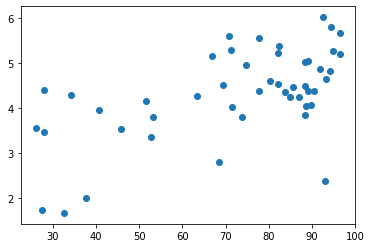

In [40]:
plt.scatter(x ,log_trend)
corr = np.corrcoef(x, log_trend)
print(corr)

In [26]:
# 回帰分析

exceptDf = stateofjs.drop('name', axis=1).drop('satisfaction', axis=1) \
.drop('download_last_year', axis=1) \
.drop('download', axis=1)

exceptDf = pd.DataFrame({"trend": exceptDf['trend'], "rate_of_change": exceptDf['rate_of_change'],
                         'mobile': exceptDf['mobile'], 'testing': exceptDf['testing'], 'backend': exceptDf['backend'], 'datalayer': exceptDf['datalayer'] })


X = exceptDf.as_matrix()
Y = stateofjs['satisfaction'].apply(lambda x: x * 0.01).as_matrix()

clf = linear_model.LinearRegression()
clf.fit(X, Y)
print('偏回帰係数', pd.DataFrame({"Name":exceptDf.columns,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
print('切片', clf.intercept_)

x_add_const = sm.add_constant(X)
model_sm = sm.OLS(Y, x_add_const).fit()
print(model_sm.summary())
result = model_sm
print('p値', round(result.pvalues[1], 6) , result.pvalues[2])

偏回帰係数              Name  Coefficients
3         testing     -0.000206
5       datalayer     -0.000197
2          mobile      0.000131
4         backend      0.000272
1  rate_of_change      0.000806
0           trend      0.001459
切片 -0.0011871422496822909
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     15.84
Date:                Wed, 08 Jan 2020   Prob (F-statistic):           2.01e-08
Time:                        16:59:31   Log-Likelihood:                 231.03
No. Observations:                  44   AIC:                            -450.1
Df Residuals:                      38   BIC:                            -439.4
Df Model:                           5                                         
Covariance Type:            nonro

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [52]:
# 回帰分析

exceptDf = stateofjs.drop('name', axis=1).drop('satisfaction', axis=1) \
.drop('download_last_year', axis=1) \
.drop('download', axis=1) \
.drop('mobile', axis=1) \
.drop('testing', axis=1) \
.drop('backend', axis=1) \
.drop('datalayer', axis=1) \

exceptDf = pd.DataFrame({"trend": exceptDf['trend'], "rate_of_change": exceptDf['rate_of_change'] })


X = exceptDf.as_matrix()
Y = stateofjs['satisfaction'].apply(lambda x: x * 0.01).as_matrix()

clf = linear_model.LinearRegression()
clf.fit(X, Y)
print('偏回帰係数', pd.DataFrame({"Name":exceptDf.columns,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
print('切片', clf.intercept_)

x_add_const = sm.add_constant(X)
model_sm = sm.OLS(Y, x_add_const).fit()
print(model_sm.summary())
result = model_sm
print('p値', result.pvalues[1] , result.pvalues[2])

偏回帰係数              Name  Coefficients
1  rate_of_change      0.000789
0           trend      0.001363
切片 -0.0007118033418348126
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     41.36
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           1.47e-10
Time:                        17:37:34   Log-Likelihood:                 230.55
No. Observations:                  44   AIC:                            -455.1
Df Residuals:                      41   BIC:                            -449.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


<class 'seaborn.axisgrid.PairGrid'>


,satisfaction,rate_of_change,download
satisfaction,1.000000,0.585898,0.692023
rate_of_change,0.585898,1.000000,0.234821
download,0.692023,0.234821,1.000000


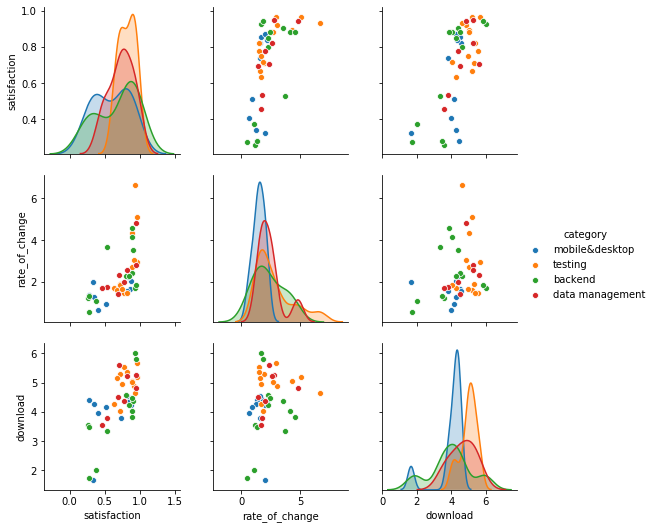

In [53]:
targetdf = stateofjs.drop('download_last_year', axis=1) \
.drop('download', axis=1)
# .drop('mobile', axis=1) \
# .drop('testing', axis=1) \
# .drop('backend', axis=1) \
# .drop('datalayer', axis=1)



targetdf.loc[targetdf['mobile'] == 1, 'category'] = "mobile&desktop"
targetdf.loc[targetdf['testing'] == 1, 'category'] = "testing"
targetdf.loc[targetdf['backend'] == 1, 'category'] = "backend"
targetdf.loc[targetdf['datalayer'] == 1, 'category'] = "data management"

targetdf = targetdf.drop('mobile', axis=1) \
.drop('testing', axis=1) \
.drop('backend', axis=1) \
.drop('datalayer', axis=1)

targetdf = targetdf.rename(columns={'trend': 'download'})
pg = sns.pairplot(targetdf, hue="category")
print(type(pg))
targetdf.corr()
# 0.692023
